<a href="https://colab.research.google.com/github/Chencc0613/Python_TradeBot/blob/main/%E6%8A%95%E8%B3%87%E8%81%96%E7%B6%932_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving ie_data.xls to ie_data (30).xls
Using file: ie_data (30).xls
Fetching CPI (FRED) ...
🔧 Extending EPS: 2023-09-01 → 2025-12-31
🎯 Shiller CAPE 最新值 = 43.583170452677706
📈 Shiller CAPE Percentile = 97.71 %

=== Scores ===
Policy score (year-level): 0.095
Tactical score (month-level): 0.641
Final market_score: 0.258
Adjusted monthly_budget: 1302.47 USD

=== Buy Allocation Preview ===
    name  target_w  current_w  weight_gap    val_pct  strength   buy_pct  \
0   NVDA     18.82          0       18.82  56.828375  0.431716  0.280563   
1    GLD      5.00          0        5.00  30.000000  0.185972  0.120859   
2    AMD      6.62          0        6.62  52.446955  0.167269  0.108705   
3    VOO     10.00          0       10.00  77.537334  0.119355  0.077566   
4   INTC      5.65          0        5.65  67.062543  0.098882  0.064262   
5    TSM      9.51          0        9.51  80.744038  0.097303  0.063235   
6   AVGO      8.24          0        8.24  81.417935  0.081358  0.052873   
7  

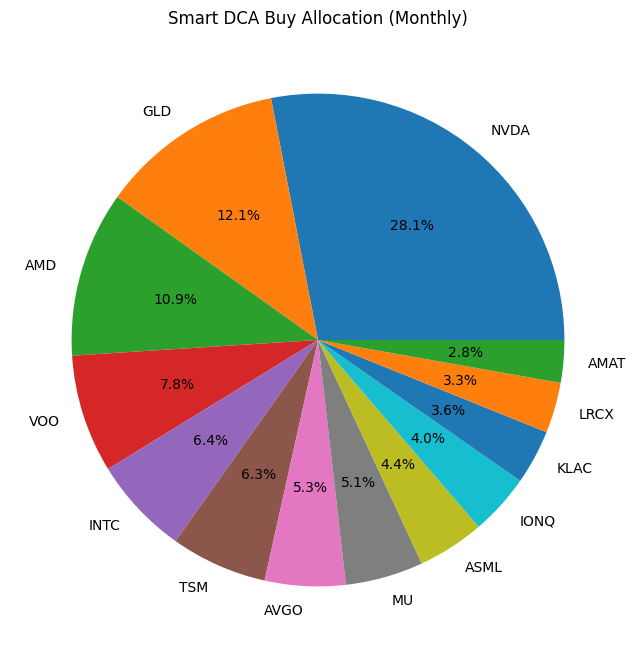

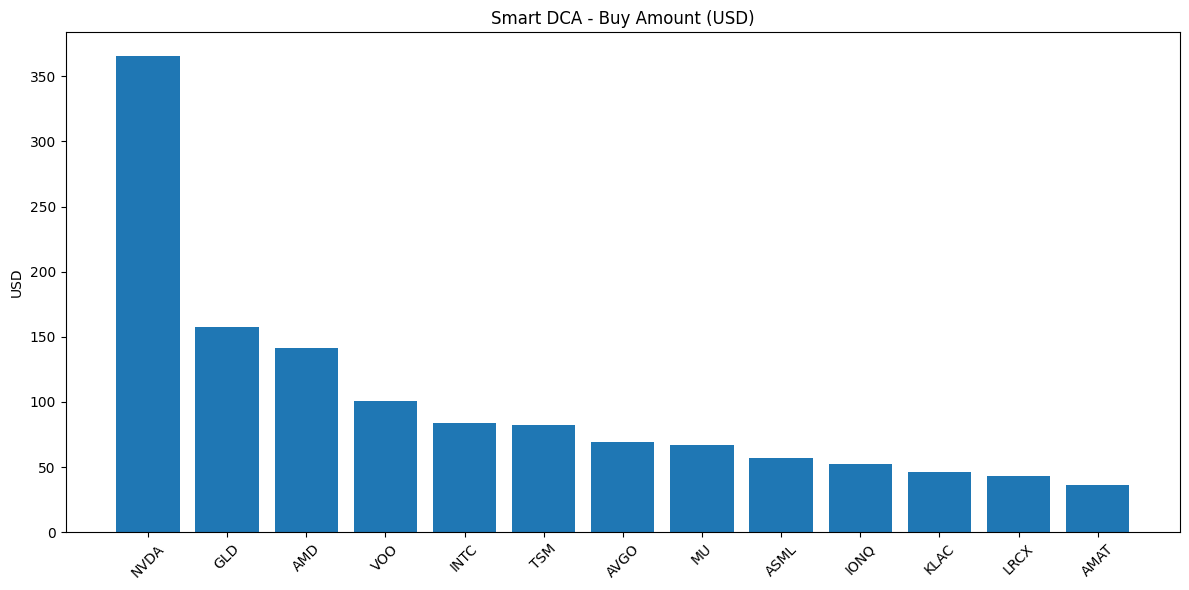

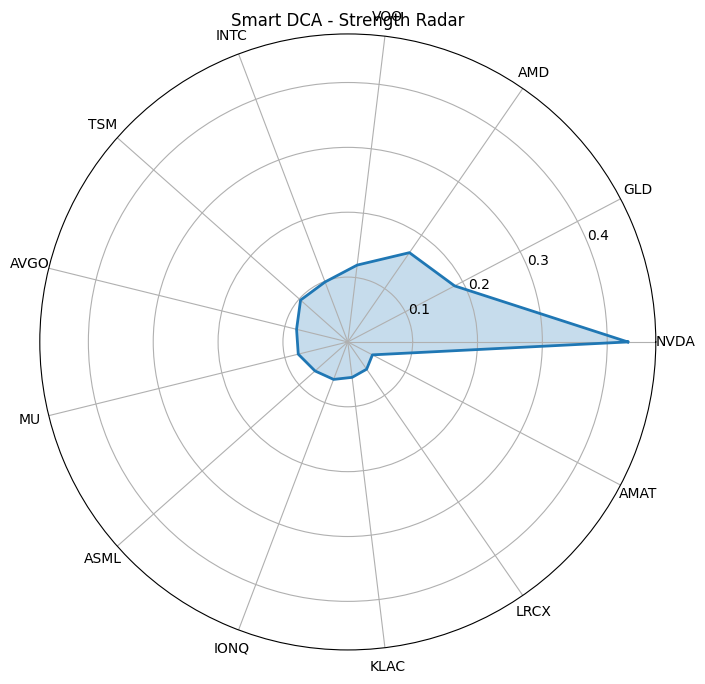


CSV saved: smart_dca_dynamic_valpct_refactor.csv

=== Next suggestions (automated) ===
- Review policy_score; if <0.3 考慮現金緩衝或部分銷售規則.
- If cape_source == 'shiller' then CAPE aligns with academic measure; otherwise it's proxy-based.
- cape_source = shiller_forced
- Consider backtesting monthly_budget and allocation over historical period before live trading.


In [34]:
# Full refactor: policy/tactical + robust CAPE (Shiller fallback) + SOX heat + safe tech indicators + allocation
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader import data as web
from datetime import datetime
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import warnings
from google.colab import files
from scipy.stats import percentileofscore

uploaded = files.upload()

file_path = list(uploaded.keys())[0]

print(f"Using file: {file_path}")

warnings.filterwarnings("ignore", category=FutureWarning)

# ============================
# User params & holdings
# ============================
monthly_basic = 5040.0

holdings = [
    {"name": "NVDA", "target_w": 18.82, "current_w": 0},
    {"name": "TSM",  "target_w": 9.51, "current_w": 0},
    {"name": "AVGO", "target_w": 8.24, "current_w": 0},
    {"name": "AMD",  "target_w": 6.62, "current_w": 0},
    {"name": "MU",   "target_w": 5.93, "current_w": 0},
    {"name": "INTC", "target_w": 5.65, "current_w": 0},
    {"name": "ASML", "target_w": 5.50, "current_w": 0},
    {"name": "LRCX", "target_w": 5.44, "current_w": 0},
    {"name": "AMAT", "target_w": 5.29, "current_w": 0},
    {"name": "KLAC", "target_w": 4.76, "current_w": 0},
    {"name": "IONQ", "target_w": 5.0,  "current_w": 0},
    {"name": "VOO",  "target_w": 10.0, "current_w": 0},
    {"name": "GLD",  "target_w": 5.0, "current_w": 0}
]

# ============================
# 1) Download SPX monthly price (for CAPE)
# ============================
print("Downloading S&P500 (^GSPC)...")
spx = yf.download("^GSPC", start="1900-01-01", auto_adjust=True, progress=False)
spx = yf.download("^GSPC", start="1900-01-01", auto_adjust=True, progress=False)

# 取 Close 欄（若是 DataFrame → Series）
price_m = spx["Close"].resample("ME").last()

# ---- 若 price_m 是 DataFrame（形狀像 (N,1)）→ 強制 squeeze ----
if isinstance(price_m, pd.DataFrame):
    price_m = price_m.squeeze("columns")

# ---- 若 squeeze 後仍是 2D array → 強制取第一欄 ----
if not isinstance(price_m, pd.Series):
    price_m = pd.Series(price_m.values.flatten(), index=price_m.index, name="price")

# ---- 再次強制 1D ----
price_m = pd.Series(price_m.values.flatten(), index=price_m.index, name="price")

start_date = price_m.index.min().replace(tzinfo=None)
end_date   = datetime.today().replace(tzinfo=None)

# ============================
# 2) CPI (FRED) fallback to proxy if necessary
# ============================
print("Fetching CPI (FRED) ...")
try:
    cpi = web.DataReader("CPIAUCSL", "fred", start_date, end_date)
    cpi = cpi.resample("ME").ffill()
    cpi = cpi.reindex(price_m.index, method="ffill")
except Exception:
    try:
        cpi_proxy = yf.download("CPI", start="1900-01-01", auto_adjust=True, progress=False)["Close"]
        cpi = pd.Series(index=price_m.index, dtype=float)
        common_idx = price_m.index.intersection(cpi_proxy.index)
        cpi.loc[common_idx] = cpi_proxy.loc[common_idx]
        cpi = cpi.bfill().ffill()
    except Exception:
        cpi = pd.Series(1.0, index=price_m.index)  # fallback (avoid divide-by-zero)

# ============================
# 3) EPS proxy (legacy fallback) - keep but not primary
# ============================
earn_yield = price_m.pct_change().rolling(12, min_periods=1).mean().abs()
earn_yield = earn_yield.replace(0, np.nan).bfill().ffill()  # prevent zeros
eps_proxy = (price_m * earn_yield).bfill().ffill()

# ============================
# 4) Build df with PE / CAPE proxy (old method) - keep for fallback
# ============================
df = pd.DataFrame(index=price_m.index)
df["Price"] = price_m
df["EPS"] = eps_proxy
df["CPI"] = cpi
# avoid division by zero
df["EPS"] = df["EPS"].replace(0, np.nan).bfill().ffill()
df["PE"] = (df["Price"] / df["EPS"]).replace([np.inf, -np.inf], np.nan).bfill().ffill()

# Real EPS and a rolling 10-year average proxy for CAPE (if needed)
df["Real_EPS"] = df["EPS"] / df["CPI"].replace(0, 1)
df["CAPE"] = (df["Price"] / df["CPI"].replace(0, 1)) / df["Real_EPS"].rolling(120, min_periods=12).mean()
df = df.dropna(subset=["Price"])  # keep price baseline

# ============================
# 5) SOX (monthly) processing: price + volume zscore, slope, final_heat
# ============================
print("Downloading ^SOX (monthly) ...")
sox = yf.download("^SOX", start="2007-01-01", end=end_date.strftime("%Y-%m-%d"), interval="1mo", progress=False)
sox = sox[["Close", "Volume"]].dropna()
sox.rename(columns={"Close": "Price", "Volume": "Volume"}, inplace=True)

# z-score normalize price and volume
sox["z_price"] = (sox["Price"] - sox["Price"].mean()) / (sox["Price"].std() + 1e-9)
sox["z_volume"] = (sox["Volume"] - sox["Volume"].mean()) / (sox["Volume"].std() + 1e-9)

# weights normalized
w_price, w_vol = 0.4, 0.2
norm_w = (w_price + w_vol) if (w_price + w_vol) != 0 else 1.0
sox["z_weighted"] = sox["z_price"] * (w_price / norm_w) + sox["z_volume"] * (w_vol / norm_w)

# Rolling slope (12 months) with linear regression
window = 12
prices = sox["Price"].values
slopes = [np.nan]*len(prices)
for i in range(len(prices)):
    if i < window:
        continue
    y = prices[i-window:i].reshape(-1, 1)
    X = np.arange(window).reshape(-1, 1)
    model = LinearRegression().fit(X, y)
    slopes[i] = float(model.coef_[0][0])
sox["slope"] = slopes

# slope z-score using rolling window (roll months)
roll = 48
sox["slope_mean"] = sox["slope"].rolling(roll, min_periods=12).mean()
sox["slope_std"]  = sox["slope"].rolling(roll, min_periods=12).std().replace(0, 1e-9)
sox["slope_z"] = ((sox["slope"] - sox["slope_mean"]) / sox["slope_std"]).clip(-2, 2)

# Improved heat scaling
lookback = 60  # 5y
low_q = sox["z_weighted"].rolling(lookback, min_periods=1).quantile(0.05)
high_q = sox["z_weighted"].rolling(lookback, min_periods=1).quantile(0.95)
den = (high_q - low_q).replace(0, np.nan).fillna(1e-9)
sox["market_heat_basic"] = 4 * (sox["z_weighted"] - low_q) / den - 2

# crisis amplifier
crisis_amp = np.where(abs(sox["slope_z"]) > 1.5, 1.2, 1.0)
sox["market_heat_basic"] = (sox["market_heat_basic"] * crisis_amp).clip(-2, 2)

# raw heat and stable mapping using historical quantiles
raw_heat = 0.7 * sox["market_heat_basic"] + 0.3 * sox["slope_z"]
low_bound = raw_heat.dropna().quantile(0.05) if not raw_heat.dropna().empty else -1.0
high_bound = raw_heat.dropna().quantile(0.95) if not raw_heat.dropna().empty else 1.0
den2 = (high_bound - low_bound) if (high_bound - low_bound) != 0 else 1e-9
sox["final_heat"] = (4 * (raw_heat - low_bound) / den2 - 2).clip(-2, 2)
crash_zone = raw_heat < raw_heat.dropna().quantile(0.05) if not raw_heat.dropna().empty else pd.Series(False, index=raw_heat.index)
sox.loc[crash_zone, "final_heat"] = (sox.loc[crash_zone, "final_heat"] * 1.15).clip(-2, 2)

# align sox with df timeline by month-end index if possible
sox.index = sox.index.to_period("M").to_timestamp("M")
sox = sox.reindex(df.index, method="ffill")

# ============================
# 6) Shiller + Proxy + CAPE 計算（最終、最穩定版）
# ============================

def empirical_percentile(series: pd.Series):
    s = series.dropna().values
    if len(s) == 0:
        return 0.5
    return percentileofscore(s, s[-1]) / 100


# -----------------------------------------
# ① 讀取本地 Shiller EPS（你的 Excel 格式專用）
# -----------------------------------------
def read_local_shiller_excel(path):
    try:
        df = pd.read_excel(
            path, sheet_name="Data", skiprows=7,
            header=0, dtype=str, engine="xlrd"
        )

        if "Date" not in df.columns or "E" not in df.columns:
            print("❌ 無 Date 或 E 欄")
            return None

        # 解析 1871.01 → datetime
        dates = []
        for x in df["Date"].astype(str):
            if "." not in x:
                dates.append(None)
                continue
            y, m = x.split(".")
            try:
                y, m = int(y), int(m)
                dates.append(datetime(y, m, 1))
            except:
                dates.append(None)

        df["Date"] = dates
        df = df.dropna(subset=["Date"]).drop_duplicates("Date")

        df = df.set_index("Date")

        eps = pd.to_numeric(df["E"], errors="coerce")

        # 以月初對齊（Shiller 原始格式）
        eps = eps.asfreq("MS").ffill().bfill()

        return eps

    except Exception as e:
        print("❌ Shiller Excel 解析失敗:", e)
        return None


# ----------------------------------------------------------
# ② Shiller EPS + Proxy EPS 補齊
# ----------------------------------------------------------
def extend_eps_with_proxy(shiller_eps, proxy_eps):
    last_real = shiller_eps.index.max()
    missing_idx = proxy_eps.index[proxy_eps.index > last_real]

    if len(missing_idx) == 0:
        return shiller_eps

    print(f"🔧 Extending EPS: {last_real.date()} → {missing_idx.max().date()}")

    proxy_part = proxy_eps.loc[missing_idx].astype(float)

    last_true = float(shiller_eps.iloc[-1])
    first_proxy = float(proxy_part.iloc[0])
    scale = last_true / first_proxy if first_proxy != 0 else 1.0

    proxy_scaled = proxy_part * scale
    out = pd.concat([shiller_eps, proxy_scaled]).sort_index()
    return out


# ----------------------------------------------------------
# ③ 主控制流程
# ----------------------------------------------------------
shiller_eps_raw = read_local_shiller_excel(file_path)
if shiller_eps_raw is None:
    raise ValueError("❌ Shiller EPS 讀取失敗")

shiller_eps = extend_eps_with_proxy(shiller_eps_raw, eps_proxy)

# 修正：強制為 Series
if isinstance(shiller_eps, pd.DataFrame):
    shiller_eps = shiller_eps.iloc[:, 0]

# ⚠️ 統一改成月末，避免與 price_m index 衝突
shiller_eps.index = shiller_eps.index.to_period("M").to_timestamp("M")

# ⚠️ 移除 Shiller EPS 重複 index（最重要的一行）
shiller_eps = shiller_eps[~shiller_eps.index.duplicated(keep="last")]

# ----------------------------------------------------------
# ④ 計算 10 年平均 EPS
# ----------------------------------------------------------
eps10 = shiller_eps.rolling(120, min_periods=36).mean()

# 保證為 1D Series
eps10 = pd.Series(eps10.values, index=eps10.index, name="earnings10")

# 同樣刪掉任何重複 index（避免 reindex 爆炸）
eps10 = eps10[~eps10.index.duplicated(keep="last")]

# 與 price_m 對齊
eps10 = eps10.reindex(price_m.index).ffill().bfill()

# ----------------------------------------------------------
# ⑤ 最終 CAPE 計算（保證不會空表）
# ----------------------------------------------------------
cape_df = pd.DataFrame({
    "price": price_m,
    "earnings10": eps10
}).dropna()

if len(cape_df) == 0:
    raise ValueError("❌ CAPE 計算失敗：eps10 與 price_m 無交集（已修復 index 但仍空表）")

cape_df["CAPE_shiller"] = cape_df["price"] / cape_df["earnings10"]

cape_percentile_emp = empirical_percentile(cape_df["CAPE_shiller"])
cape_percentile = cape_percentile_emp * 100

print("🎯 Shiller CAPE 最新值 =", cape_df["CAPE_shiller"].iloc[-1])
print("📈 Shiller CAPE Percentile =", round(cape_percentile, 2), "%")


# ============================
# 7) Technical indicators (VOO) - robust implementations
# ============================
def get_price(ticker):
    try:
        data = yf.download(ticker, period="6mo", interval="1d", auto_adjust=True, progress=False)
        data = data.dropna()
        if data.empty:
            return None
        return data
    except Exception:
        return None

def macd_signal(df):
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    macd_line = ema12 - ema26
    signal = macd_line.ewm(span=9, adjust=False).mean()
    return float((macd_line - signal).iloc[-1])

def rsi_val(df, period=14):
    delta = df['Close'].diff()
    gain = delta.clip(lower=0)
    loss = (-delta).clip(lower=0)
    avg_gain = gain.rolling(period, min_periods=1).mean()
    avg_loss = loss.rolling(period, min_periods=1).mean().replace(0, 1e-9)
    rs = avg_gain / avg_loss
    val = 100 - (100 / (1 + rs.iloc[-1]))
    return float(np.clip(val, 0, 100))

def kd_val(df, period=14):
    low_min = df["Low"].rolling(period, min_periods=1).min()
    high_max = df["High"].rolling(period, min_periods=1).max()
    denom = (high_max - low_min).replace(0, 1e-9)
    k_series = ((df["Close"] - low_min) / denom * 100)
    k = float(k_series.iloc[-1])
    d = float(k_series.rolling(3, min_periods=1).mean().iloc[-1])
    return k, d

df_voo = get_price("VOO")
if df_voo is None:
    macd_val = 0.0
    rsi_v = 50.0
    k_v = 50.0
    d_v = 50.0
else:
    macd_val = macd_signal(df_voo)
    rsi_v = rsi_val(df_voo)
    k_v, d_v = kd_val(df_voo)

# normalize tech indicators into 0..1 scale
def normalize_indicator(macd, rsi, k, d):
    rsi_s = 1 - abs(rsi - 50) / 50
    kd_s = 1 - abs((k + d)/2 - 50)/50
    macd_s = 1 / (1 + np.exp(-macd*5))
    return float(np.clip((rsi_s + kd_s + macd_s) / 3, 0.0, 1.0))

tech_score = normalize_indicator(macd_val, rsi_v, k_v, d_v)

# ============================
# 8) Convert SOX slope z and slope_norm to 0..1 (empirical percentile)
# ============================
sox_slope_series = sox["slope_z"].dropna()
if len(sox_slope_series) > 0:
    sox_slope_norm = float(sox_slope_series.rank(pct=True).iloc[-1])
else:
    sox_slope_norm = 0.5

# sox_z long-term (use final_heat as long term indicator) -> convert to 0..1 via empirical percentile
sox_final_series = sox["final_heat"].dropna()
if len(sox_final_series) > 0:
    sox_z_norm = float(sox_final_series.rank(pct=True).iloc[-1])
else:
    sox_z_norm = 0.5

# PE percentile for policy_score
if "PE" in df.columns and not df["PE"].dropna().empty:
    pe_percentile = float(df["PE"].rank(pct=True).iloc[-1])
else:
    pe_percentile = 0.5

# ============================
# 9) Policy / Tactical scores (per your design)
# ============================
# policy_score (year-level): CAPE 60%, SOX long-term 30%, P/E 10%
policy_score = (
    0.6 * (1 - cape_percentile_emp) +  # lower CAPE -> more aggressive
    0.3 * (1 - sox_z_norm) +           # lower long-term SOX heat -> more aggressive
    0.1 * (1 - pe_percentile)          # lower PE -> more aggressive
)
policy_score = float(np.clip(policy_score, 0.0, 1.0))

# tactical_score (month-level): SOX_slope 50%, VOO_tech 30%, CAPE 20%
tactical_score = (
    0.5 * sox_slope_norm +
    0.3 * tech_score +
    0.2 * (1 - cape_percentile_emp)
)
tactical_score = float(np.clip(tactical_score, 0.0, 1.0))

# final market_score (we let policy dominate): 70% policy, 30% tactical, clipped 0..1
market_score = float(np.clip(policy_score * 0.7 + tactical_score * 0.3, 0.0, 1.0))
monthly_budget = monthly_basic * market_score

print("\n=== Scores ===")
print(f"Policy score (year-level): {policy_score:.3f}")
print(f"Tactical score (month-level): {tactical_score:.3f}")
print(f"Final market_score: {market_score:.3f}")
print(f"Adjusted monthly_budget: {monthly_budget:.2f} USD")

# ============================
# 10) Dynamic val_pct and allocation (robust)
# ============================
def calc_val_pct(ticker):
    df = get_price(ticker)
    if df is None or df.empty:
        return 50.0
    try:
        r = rsi_val(df)
        k_val, d_val = kd_val(df)
        val_pct = (r + (k_val + d_val)/2) / 2
        val_pct = float(np.clip(val_pct, 10.0, 90.0))
    except Exception:
        val_pct = 50.0
    return val_pct

for h in holdings:
    if h["name"] != "GLD":
        h["val_pct"] = calc_val_pct(h["name"])
    else:
        h["val_pct"] = 30.0  # keep gold lower val_pct as example

# Strength calculation with improved normalisation
results = []
max_gap = max(abs(h["target_w"] - h["current_w"]) for h in holdings) if len(holdings)>0 else 1.0
max_gap = max_gap if max_gap > 0 else 1.0

for h in holdings:
    w_gap = h["target_w"] - h["current_w"]
    # only positive gaps => candidate for buy; negative gaps => skip (or could be sell signal elsewhere)
    w_gap_positive = max(w_gap, 0.0)
    w_gap_norm = np.clip(w_gap_positive / (max_gap + 1e-9), 0.0, 1.0)
    val_m = (100.0 - h["val_pct"]) / 100.0  # 0..1, larger when cheaper
    strength = w_gap_norm * val_m
    results.append({
        "name": h["name"],
        "weight_gap": w_gap,
        "val_pct": h["val_pct"],
        "strength": strength,
        "target_w": h["target_w"],
        "current_w": h["current_w"]
    })

df_alloc = pd.DataFrame(results)
total_strength = df_alloc["strength"].sum()
if total_strength <= 0:
    df_alloc["buy_pct"] = 0.0
else:
    df_alloc["buy_pct"] = df_alloc["strength"] / total_strength

df_alloc["buy_amount"] = df_alloc["buy_pct"] * monthly_budget

df_alloc = df_alloc.sort_values("buy_amount", ascending=False).reset_index(drop=True)

print("\n=== Buy Allocation Preview ===")
print(df_alloc[["name","target_w","current_w","weight_gap","val_pct","strength","buy_pct","buy_amount"]])

# ============================
# 11) Charts & Export
# ============================
# Pie
plt.figure(figsize=(8,8))
nonzero = df_alloc[df_alloc["buy_pct"]>0]
plt.pie(nonzero["buy_pct"], labels=nonzero["name"], autopct="%1.1f%%")
plt.title("Smart DCA Buy Allocation (Monthly)")
plt.show()

# Bar
plt.figure(figsize=(12,6))
plt.bar(df_alloc["name"], df_alloc["buy_amount"])
plt.xticks(rotation=45)
plt.title("Smart DCA - Buy Amount (USD)")
plt.ylabel("USD")
plt.tight_layout()
plt.show()

# Radar-like (simple)
labels = df_alloc["name"].tolist()
values = df_alloc["strength"].tolist()
if len(values) > 0:
    vals = values + values[:1]
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, vals, linewidth=2)
    ax.fill(angles, vals, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title("Smart DCA - Strength Radar")
    ax.set_ylim(0, max(vals)*1.1)
    plt.show()

# Save CSV
out_csv = "smart_dca_dynamic_valpct_refactor.csv"
df_alloc.to_csv(out_csv, index=False)
print(f"\nCSV saved: {out_csv}")

# ============================
# 12) Suggested next actions printed to user
# ============================
print("\n=== Next suggestions (automated) ===")
print("- Review policy_score; if <0.3 考慮現金緩衝或部分銷售規則.")
print("- If cape_source == 'shiller' then CAPE aligns with academic measure; otherwise it's proxy-based.")
print(f"- cape_source = {cape_source}")
print("- Consider backtesting monthly_budget and allocation over historical period before live trading.")


In [ ]:
# =====================================================
# 📦 LIBRARIES
# =====================================================
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import linregress

# =====================================================
# ⚙️ BASIC CONFIG
# =====================================================
ticker_voo = "VOO"
ticker_sox = "^SOX"
monthly_basic = 5040

# =====================================================
# 📥 DOWNLOAD DATA
# =====================================================
voo = yf.download(ticker_voo, period="10y", interval="1d")
sox = yf.download(ticker_sox, period="10y", interval="1mo")

voo.dropna(inplace=True)
sox.dropna(inplace=True)

# =====================================================
# 🔧 VOO Technicals
# =====================================================
def calc_rsi(df, period=14):
    delta = df["Close"].diff()
    gain = delta.clip(lower=0)
    loss = (-delta).clip(lower=0)
    avg_gain = gain.rolling(period, min_periods=1).mean()
    avg_loss = loss.rolling(period, min_periods=1).mean().replace(0, 1e-9)
    rs = avg_gain / avg_loss
    return float(100 - (100 / (1 + rs.iloc[-1])))

def calc_kd(df, period=14):
    low_min = df["Low"].rolling(period, min_periods=1).min()
    high_max = df["High"].rolling(period, min_periods=1).max()
    denom = (high_max - low_min).replace(0, 1e-9)
    k = ((df["Close"] - low_min) / denom * 100).iloc[-1]
    d = pd.Series(k).rolling(3, min_periods=1).mean().iloc[-1]
    return float(k), float(d)

voo["EMA12"] = voo["Close"].ewm(span=12).mean()
voo["EMA26"] = voo["Close"].ewm(span=26).mean()
macd_val = float((voo["EMA12"] - voo["EMA26"]).iloc[-1])
rsi_val = calc_rsi(voo)
k_val, d_val = calc_kd(voo)

tech_score = np.mean([
    1 - abs(rsi_val - 50) / 50,
    1 - abs(k_val - 50) / 50,
    1 / (1 + np.exp(-macd_val))
])

# =====================================================
# 🔥 SOX Z + Slope
# =====================================================
sox["ret"] = sox["Close"].pct_change()

sox["z_price"] = (sox["Close"] - sox["Close"].rolling(36).mean()) / sox["Close"].rolling(36).std()
sox["z_volume"] = (sox["Volume"] - sox["Volume"].rolling(36).mean()) / sox["Volume"].rolling(36).std()

w_p, w_v = 0.4, 0.2
norm = w_p + w_v

sox["z_weighted"] = sox["z_price"]*(w_p/norm) + sox["z_volume"]*(w_v/norm)

# slope regression
def calc_slope(x):
    y = np.arange(len(x))
    if len(x) < 6:
        return np.nan
    return linregress(y, x)[0]

sox["slope"] = sox["Close"].rolling(12).apply(calc_slope)

roll = 48
sox["slope_mean"] = sox["slope"].rolling(roll, min_periods=12).mean()
sox["slope_std"] = sox["slope"].rolling(roll, min_periods=12).std().replace(0, 1e-9)
sox["slope_z"] = ((sox["slope"] - sox["slope_mean"]) / sox["slope_std"]).clip(-2, 2)

sox_z_val = float(sox["z_weighted"].iloc[-1])
sox_slope_z = float(sox["slope_z"].dropna().iloc[-1])

# =====================================================
# 📊 CAPE / PE (Simplified Proxy)
# =====================================================
spx = yf.download("^GSPC", period="20y", interval="1mo")
price_m = spx["Close"].resample("ME").last()

earn_yield = price_m.pct_change().abs().rolling(12).mean().replace(0, np.nan).bfill()
eps_proxy = price_m * earn_yield

cape = price_m / eps_proxy.rolling(120).mean()

cape_series = cape.dropna()
cape_percentile_emp = float(cape_series.rank(pct=True).iloc[-1] * 100)

pe = price_m / eps_proxy
pe_series = pe.dropna()
pe_percentile = float(pe_series.rank(pct=True).iloc[-1] * 100)

# =====================================================
# ✅ BUY ENGINE (Policy + Tactical)
# =====================================================
def pct_norm(series):
    if len(series) < 10:
        return 0.5
    return float(series.rank(pct=True).iloc[-1])

sox_slope_norm = pct_norm(sox["slope_z"].dropna())

policy_score = 0.6*(1 - cape_percentile_emp/100) + 0.3*(1 - sox_slope_norm) + 0.1*(1 - pe_percentile/100)
tactical_score = 0.5*sox_slope_norm + 0.3*tech_score + 0.2*(1 - cape_percentile_emp/100)

market_score = float(np.clip(policy_score*0.7 + tactical_score*0.3, 0, 1))
monthly_budget = monthly_basic * market_score

print(f"🟢 Market Score: {market_score:.2f}")
print(f"💰 Monthly Buy Budget: {monthly_budget:,.0f}")

# =====================================================
# 🔴 SELL ENGINE (Integrated)
# =====================================================
def norm_to_01(x, low=-2, high=2):
    return np.clip((x - low) / (high - low), 0, 1)

cape_overheat = cape_percentile_emp / 100
pe_overheat = pe_percentile / 100
sox_overheat = norm_to_01(sox_z_val)
sox_slope_overheat = norm_to_01(sox_slope_z)

strategic_sell_pressure = 0.6*cape_overheat + 0.3*sox_overheat + 0.1*pe_overheat
tactical_sell_pressure = 0.7*sox_slope_overheat + 0.3*tech_score

daily_sell_trigger = 0
if rsi_val > 75: daily_sell_trigger += 1
if k_val > 85 and d_val > 85: daily_sell_trigger += 1
if macd_val < 0: daily_sell_trigger += 1

sell_score = float(strategic_sell_pressure*50 + tactical_sell_pressure*30 + daily_sell_trigger*5)

if sell_score >= 80:
    sell_signal = "STRONG_SELL"
elif sell_score >= 60:
    sell_signal = "SELL"
elif sell_score >= 40:
    sell_signal = "REDUCE"
else:
    sell_signal = "HOLD"

print(f"🔴 Sell Score: {sell_score:.1f}")
print(f"📉 Sell Signal: {sell_signal}")



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


🟢 Market Score: 0.49
💰 Monthly Buy Budget: 2,452
🔴 Sell Score: nan
📉 Sell Signal: HOLD
